In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split

import tensorflow as tf
print(tf.__version__)

2.1.0


In [2]:
# preparing data

TRAIN_DIR = "train"
TEST_DIR = "test1"

TRAIN_SIZE = len([name for name in os.listdir(TRAIN_DIR)])
TEST_SIZE = len([name for name in os.listdir(TEST_DIR)])
print("Number of training images:", TRAIN_SIZE)
print("Number of test images:", TEST_SIZE)

VALID_FRACTION = 0.2
BATCH_SIZE = 100
EPOCHS = 50

IMAGE_WIDTH = IMAGE_HEIGHT = 150

# creating df with train labels
train_filenames = os.listdir(TRAIN_DIR)
train_labels = []
for filename in train_filenames:
    label = filename.split('.')[0]
    train_labels.append(label)

train_df = pd.DataFrame({
    'id': train_filenames,
    'label': train_labels
})

# splitting to train & valid
train_df, valid_df = train_test_split(train_df, test_size=VALID_FRACTION)

# augmentation settings, for now just normalizing
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(    
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255.,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

# not doing any data augmentation on validation test set
valid_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

# creating train and valid generators (not using valid_split to avoid doing data augmentation on validation set)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_DIR, 
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df, 
    TRAIN_DIR, 
    x_col='id',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Number of training images: 25000
Number of test images: 12500
Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [3]:
model = tf.keras.models.Sequential([
    # the images were resized by ImageDataGenerator 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # since we have only 2 classes to predict we can use 1 neuron and sigmoid
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
    loss='binary_crossentropy',
    metrics = ['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
    mode='min',
    restore_best_weights=True, 
    verbose=1,
    patience=5)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

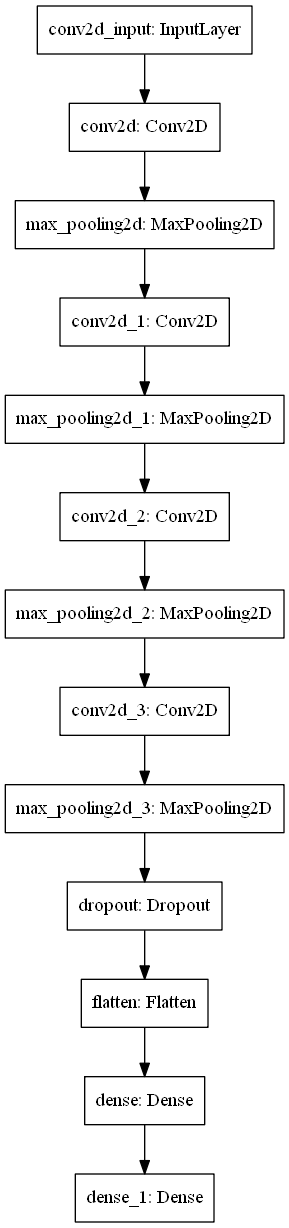

In [4]:
tf.keras.utils.plot_model(model)

In [5]:
%%time

# training
history = model.fit_generator(train_generator,
    validation_data=valid_generator,
    steps_per_epoch=round(TRAIN_SIZE*(1.-VALID_FRACTION)/BATCH_SIZE),
    validation_steps=round(TRAIN_SIZE*VALID_FRACTION/BATCH_SIZE),
    epochs=EPOCHS,
    callbacks=[es],
    verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 200 steps, validate for 50 steps
Epoch 1/50
200/200 [==============================] - 617s 3s/step - loss: 0.6978 - accuracy: 0.5588 - val_loss: 0.6457 - val_accuracy: 0.6090
Epoch 2/50
200/200 [==============================] - 254s 1s/step - loss: 0.6389 - accuracy: 0.6366 - val_loss: 0.5795 - val_accuracy: 0.6990
Epoch 3/50
200/200 [==============================] - 157s 783ms/step - loss: 0.6052 - accuracy: 0.6748 - val_loss: 0.5332 - val_accuracy: 0.7324
Epoch 4/50
200/200 [==============================] - 150s 751ms/step - loss: 0.5747 - accuracy: 0.7010 - val_loss: 0.5232 - val_accuracy: 0.7436
Epoch 5/50
200/200 [==============================] - 196s 982ms/step - loss: 0.5530 - accuracy: 0.7235 - val_loss: 0.5802 - val_accuracy: 0.6968
Epoch 6/50
200/200 [==============================] - 137s 687ms/step - loss: 0.5316 - accuracy: 0.7388 - v

In [6]:
model.save('modelo_cvsd.h5')
model.save_weights('modelo_pesos_cvsd.h5')


Text(0.5, 1.0, 'Training and validation loss')

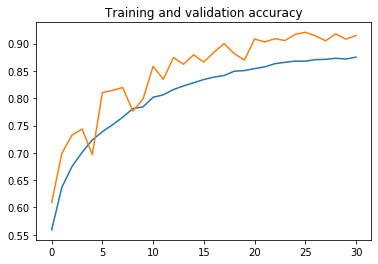

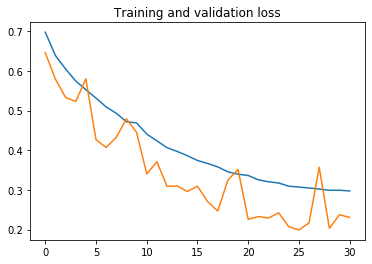

In [7]:
#plotting

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['accuracy']
val_acc = history.history[ 'val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [8]:
%%time

# preparing testing data
test_filenames = os.listdir(TEST_DIR)
test_df = pd.DataFrame({
    'id': test_filenames
})

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.)

test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    TEST_DIR, 
    x_col='id',
    y_col=None,
    class_mode=None,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False
)

yhat = model.predict_generator(test_generator, steps=np.ceil(TEST_SIZE/BATCH_SIZE))

Found 12500 validated image filenames.
Instructions for updating:
Please use Model.predict, which supports generators.
Wall time: 1min 37s


In [9]:
# sigmoid returns probability between 0 and 1, need to convert it to an integer class
yhat = [1 if y > 0.5 else 0 for y in yhat]

test_df['label'] = yhat

# restoring back to class names (dog|cat)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['label'] = test_df['label'].replace(label_map)

# encoding according to submission format, 1 = dog, 0 = cat
test_df['label'] = test_df['label'].replace({ 'dog': 1, 'cat': 0 })

test_df.to_csv('submission.csv', index=False)

In [11]:
test_df.head(19)

,id,label
0,1.jpg,1
1,10.jpg,0
2,100.jpg,0
3,1000.jpg,1
4,10000.jpg,1
5,10001.jpg,0
6,10002.jpg,0
7,10003.jpg,1
8,10004.jpg,1
9,10005.jpg,0


In [ ]:
%%time

# training
history = model.fit_generator(train_generator,
    validation_data=valid_generator,
    steps_per_epoch=round(TRAIN_SIZE*(1.-VALID_FRACTION)/BATCH_SIZE),
    validation_steps=round(TRAIN_SIZE*VALID_FRACTION/BATCH_SIZE),
    epochs=EPOCHS,
    callbacks=[es],
    verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 200 steps, validate for 50 steps
Epoch 1/50
200/200 [==============================] - 140s 700ms/step - loss: 0.2950 - accuracy: 0.8766 - val_loss: 0.2181 - val_accuracy: 0.9098
Epoch 2/50
200/200 [==============================] - 141s 705ms/step - loss: 0.2905 - accuracy: 0.8759 - val_loss: 0.2073 - val_accuracy: 0.9198
Epoch 3/50
200/200 [==============================] - 145s 727ms/step - loss: 0.2955 - accuracy: 0.8746 - val_loss: 0.2284 - val_accuracy: 0.9044
Epoch 4/50
200/200 [==============================] - 143s 717ms/step - loss: 0.2887 - accuracy: 0.8777 - val_loss: 0.2537 - val_accuracy: 0.9142
Epoch 5/50
200/200 [==============================] - 148s 741ms/step - loss: 0.2768 - accuracy: 0.8832 - val_loss: 0.2368 - val_accuracy: 0.8960
Epoch 6/50
200/200 [==============================] - 147s 733ms/step - loss: 0.2827 - accuracy: 0.8830 - val_loss: 0.3418 - val_accuracy: 0.8418
Epoch 7/50
200/200 [===========

In [13]:
model.save('modelo2_cvsd.h5')
model.save_weights('modelo2_pesos_cvsd.h5')

Text(0.5, 1.0, 'Training and validation loss')

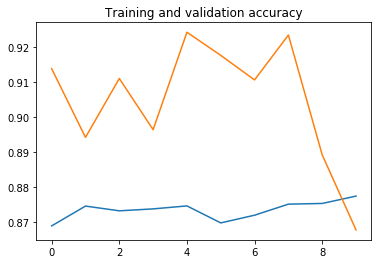

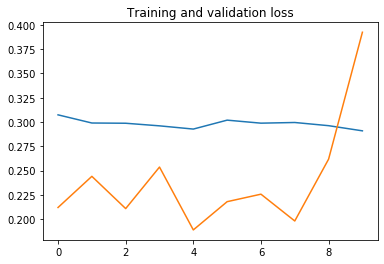

In [14]:
#plotting

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['accuracy']
val_acc = history.history[ 'val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')